In [1]:
#Packages.
from scipy.integrate import odeint      #ODE calculations for SIR

#Modules.
import Functions as fun

%matplotlib inline
%pylab inline

#Plotting parameters.
font = {'weight' : 'normal','size'   : 20}
rc('font', **font)
rc('lines', linewidth=2)

myColors = plt.cm.Spectral(concatenate([arange(0,0.35,1/12.),arange(0.6,1.05,1/12.)]))

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Parameters.
R0 = 1.4              #Basic reproduction number.
gamma = 5.0/7.0      #Waning immunity rate. Mean beta distribution = alpha/(alpha+beta) = 10/12
Vc = 0.1              #Vaccine coverage.
Ve = 0.5              #Vaccine efficiency.

Years = range(0,20)
stepsSeason = 1000

In [3]:
#Timeseries functions, deterministic.
def timeseriesDeterministicIntroductionVaccination(R0, gamma, Vc, Ve, years):
    timeseriesFinal, timeseriesSusc = fun.timeseriesDeterministic(R0, gamma, 0.0, 0.0, range(7))

    for year in years[7:]:
        s0 = timeseriesSusc[-1]
        finalSize, susceptibility = fun.giveNextSusceptibility(R0,gamma,Vc,Ve,s0)
    
        timeseriesFinal += [ finalSize ]
        timeseriesSusc += [ susceptibility ]
    
    return timeseriesFinal, timeseriesSusc

In [4]:
#Timeseries functions, stochastic.
import random as rnd

def timeseriesStochasticIntroductionVaccination(R0,Vc,Ve,years):
    timeseriesFinal, timeseriesSusc = fun.timeseriesStochastic(R0, 0.0, 0.0, range(7),average=False)

    for year in years[7:]:
        
        gamma = rnd.betavariate(5,2)
        
        s0 = timeseriesSusc[-1]
        finalSize, susceptibility = fun.giveNextSusceptibility(R0,gamma,Vc,Ve,s0)
        
        timeseriesFinal += [ finalSize ]
        timeseriesSusc += [ susceptibility ]

    return timeseriesFinal, timeseriesSusc

In [5]:
#Calculating mean peak incidence pre- and post-vaccination for 1000 seasons.

#Determinisitic.
finDet, suscDet = fun.timeseriesDeterministic(R0, gamma, 0.0, 0.0, Years)
timeSeason, y = fun.SIRseason(R0,suscDet[-1])
peakDeterministicPre = max(y[:,1])

finDet, suscDet = fun.timeseriesDeterministic(R0, gamma, Vc, Ve, Years)
timeSeason, y = fun.SIRseason(R0,suscDet[-1])
peakDeterministicPost = max(y[:,1])
    
    
#Stochastic.

peakStochasticPre = []
finStoch, suscStoch = fun.timeseriesStochastic(R0, 0.0, 0.0, range(1000), average=False)
for s0 in suscStoch:
    timeSeason, y = fun.SIRseason(R0,s0)
    peakStochasticPre += [max(y[:,1])]
    
peakStochasticPost = []
finStoch, suscStoch = fun.timeseriesStochastic(R0, Vc, Ve, range(1000), average=False)
for s0 in suscStoch:
    timeSeason, y = fun.SIRseason(R0,s0)
    peakStochasticPost += [max(y[:,1])]

In [12]:
#Calculate final size and susceptibility timeseries.

finDet, suscDet = timeseriesDeterministicIntroductionVaccination(R0, gamma, Vc, Ve, Years)
finStoch, suscStoch = timeseriesStochasticIntroductionVaccination(R0, Vc, Ve, Years)

#Generating SIR-model-sequence over several years.

timeAxis = range(len(Years)*stepsSeason)

infectedsDeterministic = []
infectedsStochastic = []

for year in Years:
    s0 = suscDet[year]
    timeSeason, y = fun.SIRseason(R0,s0)
    infectedsDeterministic.extend(y[:,1])

    s0 = suscStoch[year]
    timeSeason, y = fun.SIRseason(R0,s0)
    infectedsStochastic.extend(y[:,1])

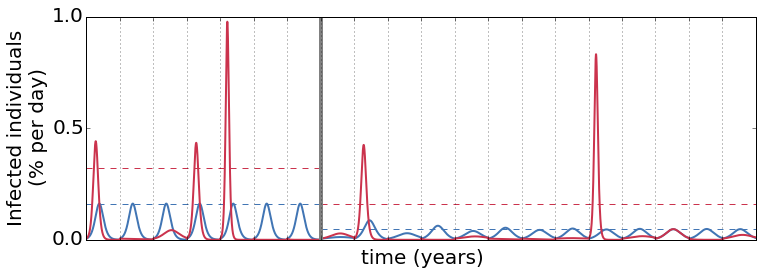

In [13]:
#Plotting timeseries, with average peak incidence values.
import matplotlib.gridspec as gridspec

fig = figure(figsize=(12,4))

ax = fig.add_subplot(111)

#Plot peak values. Deterministic.
ax.plot([timeAxis[0],timeAxis[7000]],[peakDeterministicPre,peakDeterministicPre],'--',lw=1,color=myColors[9])
ax.plot([timeAxis[7000],timeAxis[-1]],[peakDeterministicPost,peakDeterministicPost],'--',lw=1,color=myColors[9])

#Plot peak values. Stochastic.
ax.plot([timeAxis[0],timeAxis[7000]],[mean(peakStochasticPre),mean(peakStochasticPre)],
         '--',lw=1,color=myColors[1])
ax.plot([timeAxis[7000],timeAxis[-1]],[mean(peakStochasticPost),mean(peakStochasticPost)],
         '--',lw=1,color=myColors[1])

#Plot timeseries.
ax.plot(timeAxis,infectedsDeterministic, color=myColors[9], label = 'Constant protection time')
ax.plot(timeAxis,infectedsStochastic, color=myColors[1], label = 'Variable protection time')

#Dummy plot for legend.
myPlot = ax.plot([0,1],[-1,-1],'--',lw=1, color = 'black', label = 'Mean peak size')

#Plot introduction of vaccination bar.
ax.plot([7*stepsSeason,7*stepsSeason],[0,0.01], color = 'gray', lw = 4)



ax.set_xticklabels([])
ax.set_xticks(range(0,len(Years)*stepsSeason,stepsSeason))
ax.set_xlabel('time (years)')

ax.set_ylabel('Infected individuals \n(% per day)')
ax.set_ylim(0,0.01)
ax.set_yticks([0,0.005,0.01])
ax.set_yticklabels(['0.0','0.5','1.0'])

ax.xaxis.grid(True)

In [14]:
#Write data for re-use.
fun.writeData('data/TimeseriesPeakDeterministicPre',peakDeterministicPre)
fun.writeData('data/TimeseriesPeakStochasticPre',peakStochasticPre)

fun.writeData('data/TimeseriesPeakDeterministicPost',peakDeterministicPost)
fun.writeData('data/TimeseriesPeakStochasticPost',peakStochasticPost)

fun.writeData('data/TimeseriesDeterministicVaccination',infectedsDeterministic)
fun.writeData('data/TimeseriesStochasticVaccination',infectedsStochastic)